In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!git clone https://github.com/NVlabs/stylegan3.git
!pip install ninja

Cloning into 'stylegan3'...
remote: Enumerating objects: 212, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 212 (delta 0), reused 1 (delta 0), pack-reused 207
Receiving objects: 100% (212/212), 4.17 MiB | 9.23 MiB/s, done.
Resolving deltas: 100% (98/98), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 7.1 MB/s eta 0:00:00


In [ ]:
!ls /content/stylegan3

avg_spectra.py	 dnnlib      environment.yml  gui_utils    metrics	training       viz
calc_metrics.py  Dockerfile  gen_images.py    legacy.py    README.md	train.py
dataset_tool.py  docs	     gen_video.py     LICENSE.txt  torch_utils	visualizer.py


In [ ]:
!python /content/stylegan3/gen_images.py \
    --network=https://api.ngc.nvidia.com/v2/models/org/nvidia/team/research/stylegan2/1/files?redirect=true&path=stylegan2-celebahq-256x256.pkl \
  --outdir=/content/results --seeds=6600-6625

/bin/bash: line 1: --outdir=/content/results: No such file or directory
Usage: gen_images.py [OPTIONS]
Try 'gen_images.py --help' for help.

Error: Missing option '--seeds'.


In [ ]:
!python stylegan3/gen_images.py --help

Usage: gen_images.py [OPTIONS]

  Generate images using pretrained network pickle.

  Examples:

  # Generate an image using pre-trained AFHQv2 model ("Ours" in Figure 1, left).
  python gen_images.py --outdir=out --trunc=1 --seeds=2 \
      --network=https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-r-afhqv2-512x512.pkl

  # Generate uncurated images with truncation using the MetFaces-U dataset
  python gen_images.py --outdir=out --trunc=0.7 --seeds=600-605 \
      --network=https://api.ngc.nvidia.com/v2/models/nvidia/research/stylegan3/versions/1/files/stylegan3-t-metfacesu-1024x1024.pkl

Options:
  --network TEXT                  Network pickle filename  [required]
  --seeds PARSE_RANGE             List of random seeds (e.g., '0,1,4-6')
                                  [required]
  --trunc FLOAT                   Truncation psi  [default: 1]
  --class INTEGER                 Class label (unconditional if not specified)
  --noise-mode [const|r

In [ ]:
import sys
sys.path.insert(0, "/content/stylegan3")
import pickle
import os
import numpy as np
import PIL.Image
from IPython.display import Image
import matplotlib.pyplot as plt
import IPython.display
import torch
import dnnlib
import legacy

def seed2vec(G, seed):
  return np.random.RandomState(seed).randn(1, G.z_dim)

def display_image(image):
  plt.axis('off')
  plt.imshow(image)
  plt.show()

def generate_image(G, z, truncation_psi):
    # Render images for dlatents initialized from random seeds.
    Gs_kwargs = {
        'output_transform': dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True),
        'randomize_noise': False
    }
    if truncation_psi is not None:
        Gs_kwargs['truncation_psi'] = truncation_psi

    label = np.zeros([1] + G.input_shapes[1][1:])
    images = G.run(z, label, **G_kwargs) # [minibatch, height, width, channel]
    return images[0]

def get_label(G, device, class_idx):
  label = torch.zeros([1, G.c_dim], device=device)
  if G.c_dim != 0:
      if class_idx is None:
          ctx.fail('Must specify class label with --class when using a conditional network')
      label[:, class_idx] = 1
  else:
      if class_idx is not None:
          print ('warn: --class=lbl ignored when running on an unconditional network')
  return label

def generate_image(device, G, z, truncation_psi=1.0, noise_mode='const', class_idx=None):
  z = torch.from_numpy(z).to(device)
  label = get_label(G, device, class_idx)
  img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
  img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  #PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/seed{seed:04d}.png')
  return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')

In [ ]:
SURL = "https://api.ngc.nvidia.com/v2/models/org/nvidia/team/research/stylegan2/1/files?redirect=true&path=stylegan2-celebahq-256x256.pkl"

print(f'Loading networks from "{URL}"...')
device = torch.device('cuda')
with dnnlib.util.open_url(URL) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Loading networks from "https://api.ngc.nvidia.com/v2/models/org/nvidia/team/research/stylegan2/1/files?redirect=true&path=stylegan2-celebahq-256x256.pkl"...


Seed 1000
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


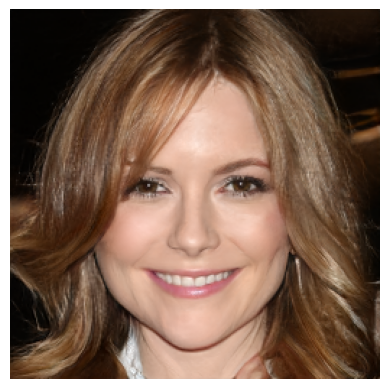

Seed 1001


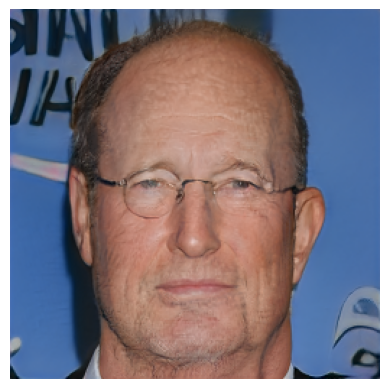

Seed 1002


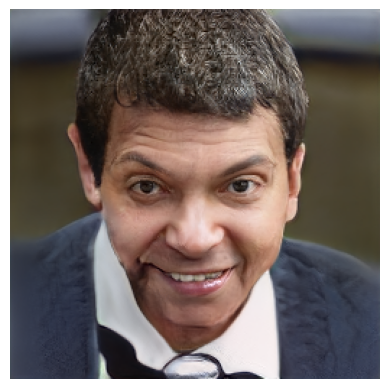

Seed 1003


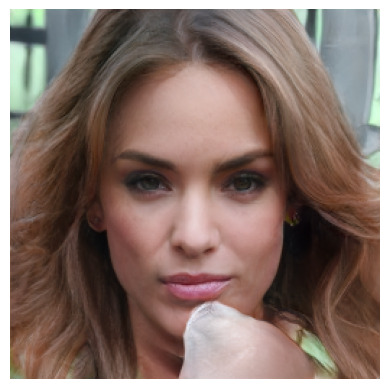

Seed 1004


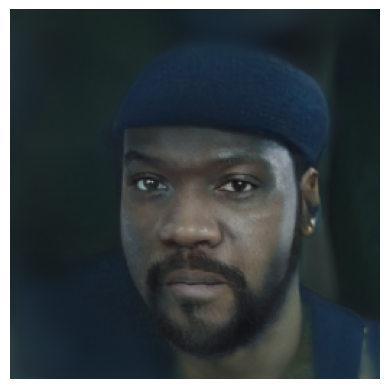

Seed 1005


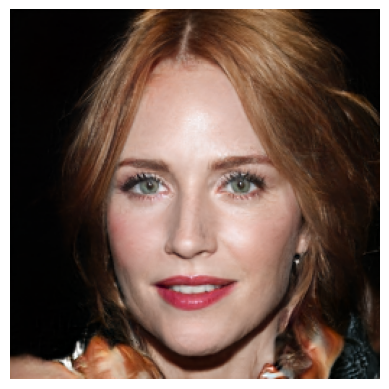

Seed 1006


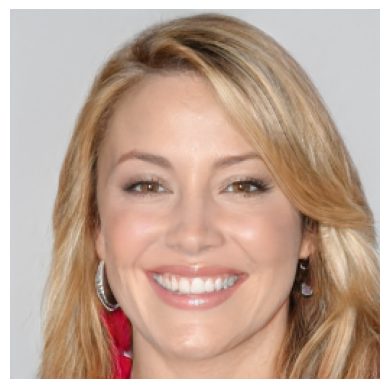

Seed 1007


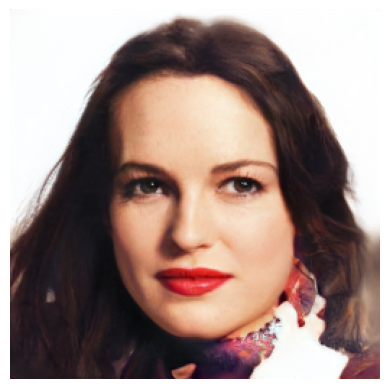

Seed 1008


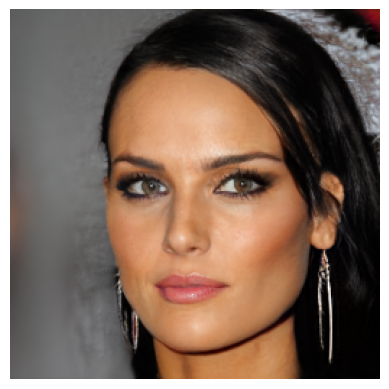

Seed 1009


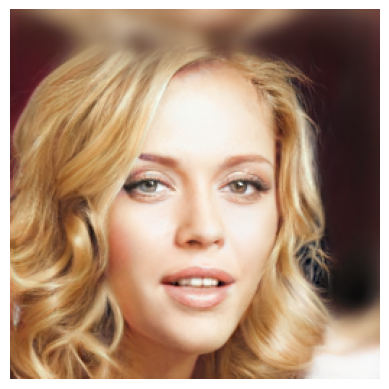

Seed 1010


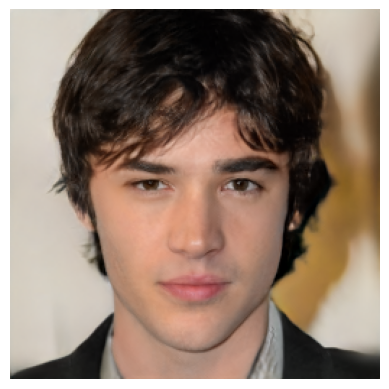

Seed 1011


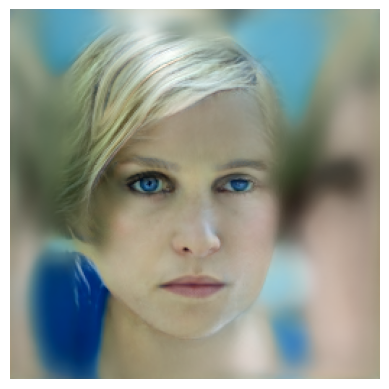

Seed 1012


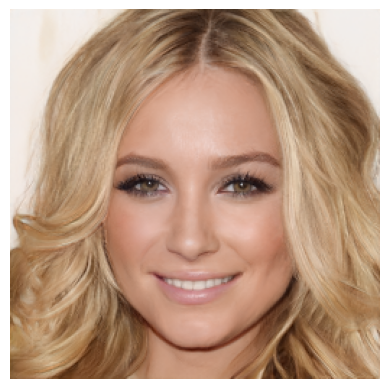

Seed 1013


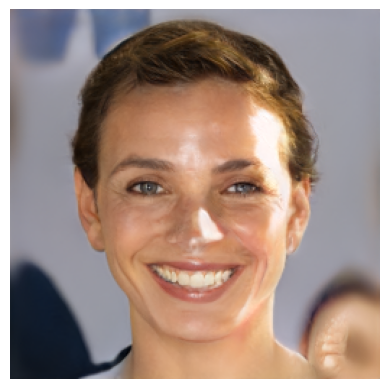

Seed 1014


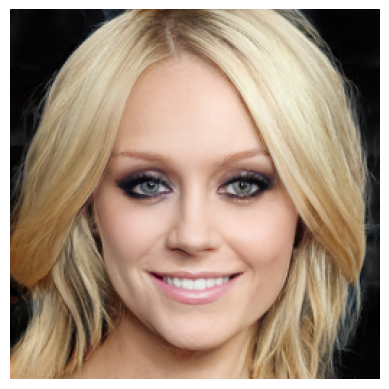

In [ ]:
# Choose your own starting and ending seed.
SEED_FROM = 1000
SEED_TO = 1015

# Generate the images for the seeds.
for i in range(SEED_FROM, SEED_TO):
  print(f"Seed {i}")
  z = seed2vec(G, i)
  img = generate_image(device, G, z)
  display_image(img)